In [1]:
import os
import time
import gc
import json
import requests
from datetime import date, timedelta, datetime

import pandas as pd
import numpy as np
import io
from pandas.io.json import json_normalize

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.html.use_mathjax', False) # от italic шрифтов

import ujson
import rapidjson
import orjson

In [75]:
dump_arr = {}

def benchmark(name, dumps):
    start = time.time()
    for i in range(500):
        dumps(data)
    print(name, time.time() - start)
    dump_arr.update({name : time.time() - start})
        

benchmark("Python default: ", json.dumps)
# orjson only outputs bytes, but often we need unicode:
benchmark("orjson: ", lambda s: str(orjson.dumps(s), "utf-8"))
benchmark("rapidjson: ", rapidjson.dumps)
benchmark("ujson: ", ujson.dumps)

Python default:  26.740447521209717
orjson:  5.626964330673218
rapidjson:  14.048872470855713
ujson:  13.809800148010254


In [76]:
dump_arr

{'Python default: ': 26.740865230560303,
 'orjson: ': 5.627078294754028,
 'rapidjson: ': 14.048988819122314,
 'ujson: ': 13.809906244277954}

In [85]:
list(dump_arr.keys())

['Python default: ', 'orjson: ', 'rapidjson: ', 'ujson: ']

<BarContainer object of 4 artists>

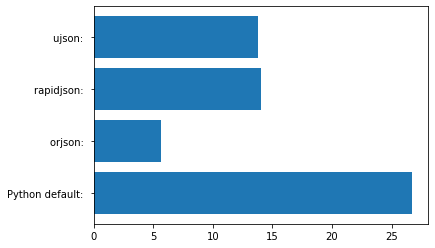

In [86]:
plt.barh(list(dump_arr.keys()), dump_arr.values(), align='center')

In [74]:
load_arr = {}
def load_benchmark(name, json_type):
    start = time.time()
    for i in range(100):
        with open(PATH, encoding="utf8") as f:
            json_type(f)
    print(name, time.time() - start)
    load_arr.update({name : 1/(time.time() - start)})

In [70]:
load_benchmark("Python default: ", json.load)
# orjson only outputs bytes, but often we need unicode:
load_benchmark("orjson: ",  lambda s:[orjson.loads(line) for line in s.readlines()]) #convert string to dict format)
load_benchmark("rapidjson: ", rapidjson.load)
load_benchmark("ujson: ", ujson.load)

Python default:  8.514800071716309
orjson:  7.503512382507324
rapidjson:  10.906418085098267
ujson:  8.531050682067871


<BarContainer object of 4 artists>

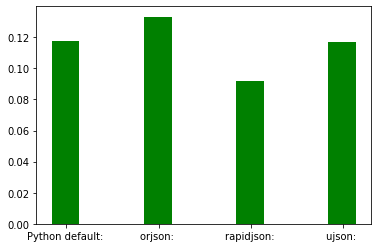

In [71]:
pos = np.arange(len(load_arr.keys()))
width = 0.3     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(pos + (width / 30))
ax.set_xticklabels(load_arr.keys())

plt.bar(load_arr.keys(), load_arr.values(), width, color='green')

In [137]:
print('{:%d, %b %Y}'.format(l))

10, Jan 2019


In [144]:
datetime.strftime(l, '%d, %b %Y')

'10, Jan 2019'

In [ ]:
date = '10/24/2019'

In [7]:
def get_data_rg(start_date, end_date):
    '''FORMAT: MM/DD/YYYY eg. '10/24/2019'
    '''
    json_arr = []
    sdate = datetime.strptime(start_date, '%m/%d/%Y')
    edate = datetime.strptime(end_date, '%m/%d/%Y')
    delta = edate - sdate
    for i in range(delta.days+1):
        day = sdate + timedelta(days=i)
        date_day = datetime.strftime(day, '%m/%d/%Y')
        response = requests.get('https://resultsdb-api.rotogrinders.com/api/contests?start='+date_day+'&lean=true')
        data = response.json()
        json_arr = json_arr + data
        time.sleep(1)
    with open('RG_{}_{}.json'.format(sdate, edate), 'w') as outfile:
        json.dump(json_arr, outfile)
    return json_arr


'''def map_sport(sportname):
    sportname = sportname.lower()
    if sportname == 'nfl':
        return 1
    if sportname == 'mlb':
        return 2
    if sportname == 'nba':
        return 3
    if sportname == 'nhl':
        return 4
    if sportname == 'golf' or sportname == 'apt':
        return 6
    return ValueError('Sport type is not tracked')
'''

def df_prep(json_data):
    df = pd.DataFrame(json_data, columns = ['name',
                                            'sport',
                                            'gameCount',
                                            'start',                                       
                                            'prizePool',
                                            'entryFee',
                                            'maxEntriesPerUser',
                                            'maxEntries',
                                            'entryCount'
                                           ])
    df['sport'] = df['sport'].map({1:'NFL',
                                   2:'MLB',
                                   3:'NBA',
                                   4:'NHL',
                                   6:'GOLF'})
    df['start'] = df['start'].apply(lambda x:x[:-1])
    df['start'] = pd.to_datetime(df['start'])
    df.insert(3, 'dayofweek', df['start'].dt.day_name())
    df.dropna(inplace=True) # Если нет mE и mEPerUser, на сайте игр нет, хотя в логах played=true. Если нет gameCount - отмененные. 
    df['maxEntries'] = df['maxEntries'].astype('int')
    df['maxEntriesPerUser'] = df['maxEntriesPerUser'].astype('int')
    df['name'] = df['name'].str.lower()
    return df

def rg_df(PATH):
    '''Supported sport types are:
    NFL, NBA, MLB, NHL, Golf
    '''
    with open(PATH, encoding="utf8") as f:
        data = f.readlines()
        data = [json.loads(line) for line in data] #convert string to dict format
    df = df_prep(data[0])
    return df

In [9]:
PATH = 'RG_10-24-19_11-07-19.json'
with open(PATH, encoding="utf8") as f:
    data = json.load(f)

In [10]:
data

[{'_id': '5db22d5dff66cb78f1d4e892',
  'winner': {'score': None, 'users': []},
  'slateType': 70,
  'gameCount': 3,
  'siteSlateId': '30807',
  'start': '2019-10-24T23:00:00.000Z',
  'sport': 3,
  'prizePool': 25000,
  'maxEntriesPerUser': 1,
  'maxEntries': 1149,
  'entryFee': 25,
  'name': 'NBA Single Entry $25 Double Up ',
  'siteContestId': '79073448',
  '_slateId': '5db22d5dff66cb78f1d4e82d',
  'entryCount': 1150,
  'rgPrizePool': 7750,
  'rgPrizeWinnerCount': 155,
  'complete': True,
  'prizes': [{'cash': 50,
    'maxFinish': 500,
    'minFinish': 1,
    'tierPayoutDescriptions': {'Cash': '$50.00'},
    'value': 50}]},
 {'_id': '5db22d5e9fa90078e9c2676b',
  'winner': {'score': None, 'users': []},
  'slateType': 70,
  'gameCount': 3,
  'siteSlateId': '30807',
  'start': '2019-10-24T23:00:00.000Z',
  'sport': 3,
  'prizePool': 450000,
  'maxEntriesPerUser': 150,
  'maxEntries': 52941,
  'entryFee': 10,
  'name': 'NBA $450K Big Jam [$100K to 1st]',
  'siteContestId': '79074503',
  '

In [286]:
arr = get_data_rg('10/01/2018', '12/31/2018')

In [2]:
from tqdm import tqdm_notebook

In [7]:
from multiprocessing import Pool

In [16]:
def get(date_day):
    json_arr = []
    time.sleep(1)
    response = requests.get('https://resultsdb-api.rotogrinders.com/api/contests?start='+date_day+'&lean=true', verify=False)
    data = response.json()
    json_arr = json_arr + data
    return json_arr
    
def get_data_rg(start_date, end_date):
    start = time.time()
    '''FORMAT: MM/DD/YYYY eg. '10/24/2019'
    '''
    dates = []
    p = Pool(4)
    sdate = datetime.strptime(start_date, '%m/%d/%Y')
    edate = datetime.strptime(end_date, '%m/%d/%Y')
    delta = edate - sdate
    for i in range(delta.days+1):
        day = sdate + timedelta(days=i)
        date_day = datetime.strftime(day, '%m/%d/%Y')
        dates.append(date_day)
    json_arr = p.map(get, dates)
    json_arr = [ent for sublist in json_arr for ent in sublist]

    with open('RG_{}_{}.json'.format(sdate, edate), 'w') as outfile:
        json.dump(json_arr, outfile)
    print (time.time()-start)
    return json_arr

In [17]:
get_data_rg('12/02/2018', '12/31/2018')

19.422590732574463


[{'_id': '5c041e77c02de35e2672e8b3',
  'winner': {'score': None, 'users': []},
  'slateType': 1,
  'gameCount': 13,
  'siteSlateId': '23056',
  'start': '2018-12-02T18:00:00.000Z',
  'sport': 1,
  'prizePool': 4000000,
  'maxEntriesPerUser': 150,
  'maxEntries': 44444,
  'entryFee': 100,
  'name': 'NFL $4M Roman 100th Millionaire Special [$1M to 1st]',
  'siteContestId': '64742955',
  '_slateId': '5c041e75c02de35e2672e6d4',
  'entryCount': 44445,
  'rgPrizePool': 682117.6600000001,
  'rgPrizeWinnerCount': 2607,
  'complete': False,
  'createdAt': '2019-11-23T22:28:42.865Z',
  'playerOwnership': [],
  'prizes': [{'value': 1000000,
    'tierPayoutDescriptions': {'Cash': '$1,000,000.00'},
    'minFinish': 1,
    'maxFinish': 1,
    'cash': 1000000},
   {'value': 150000,
    'tierPayoutDescriptions': {'Cash': '$150,000.00'},
    'minFinish': 2,
    'maxFinish': 2,
    'cash': 150000},
   {'value': 100000,
    'tierPayoutDescriptions': {'Cash': '$100,000.00'},
    'minFinish': 3,
    'maxFi

In [4]:
%time
get_data_rg('12/01/2018', '12/31/2018')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


[{'_id': '5c03d8e3c02de35e2670ec97',
  'winner': {'score': None, 'users': []},
  'slateType': 4,
  'gameCount': 2,
  'siteSlateId': '23221',
  'start': '2018-12-01T18:00:00.000Z',
  'sport': 4,
  'prizePool': 12500,
  'maxEntriesPerUser': 55,
  'maxEntries': 1838,
  'entryFee': 8,
  'name': 'NHL $12.5K Early Eight [2x Min Cash, $2K to 1st] (Early)',
  'siteContestId': '65467067',
  '_slateId': '5c03d8e1c02de35e2670e4a3',
  'entryCount': 1537,
  'rgPrizePool': 4380.469999999999,
  'rgPrizeWinnerCount': 110,
  'complete': True,
  'createdAt': '2019-11-23T22:10:54.870Z',
  'playerOwnership': [],
  'prizes': [{'value': 2000,
    'tierPayoutDescriptions': {'Cash': '$2,000.00'},
    'minFinish': 1,
    'maxFinish': 1,
    'cash': 2000},
   {'value': 1000,
    'tierPayoutDescriptions': {'Cash': '$1,000.00'},
    'minFinish': 2,
    'maxFinish': 2,
    'cash': 1000},
   {'value': 750,
    'tierPayoutDescriptions': {'Cash': '$750.00'},
    'minFinish': 3,
    'maxFinish': 3,
    'cash': 750},
 

In [1]:
def get_data_rg(start_date, end_date):
    '''FORMAT: MM/DD/YYYY eg. '10/24/2019'
    '''
    json_arr = []
    sdate = datetime.strptime(start_date, '%m/%d/%Y')
    edate = datetime.strptime(end_date, '%m/%d/%Y')
    delta = edate - sdate
    for i in tqdm_notebook(range(delta.days+1)):
        day = sdate + timedelta(days=i)
        date_day = datetime.strftime(day, '%m/%d/%Y')
        data = faster_requests.get2dict('https://resultsdb-api.rotogrinders.com/api/contests?start='+date_day+'&lean=true')
        json_arr.append(data)
        time.sleep(1)
    with open('RG_{}_{}.json'.format(sdate, edate), 'w') as outfile:
        json.dump(json_arr, outfile)
    return json_arr

In [ ]:
%time
get_data_rg('12/01/2018', '12/31/2018')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [87]:
!pip install faster-than-requests

     |████████████████████████████████| 276kB 880kB/s eta 0:00:01
  Created wheel for faster-than-requests: filename=faster_than_requests-0.5-cp37-cp37m-linux_x86_64.whl size=127956 sha256=7e426239311298b03d703697e45c2db178ce7643de1181795276c3c2183a0985
  Stored in directory: /home/hq/.cache/pip/wheels/17/ef/66/42b3e21e024159da63cc8d328d127fe73cd2e1353855493917
Successfully built faster-than-requests


In [3]:
import faster_than_requests as faster_requests

In [ ]:
for req in []

In [298]:
df = df_prep(arr)
df['month'] = df['start'].apply(lambda x:x.strftime('%B'))

In [300]:
end = pd.to_datetime('01/01/2019')

df = df.loc[df['start'] < end]

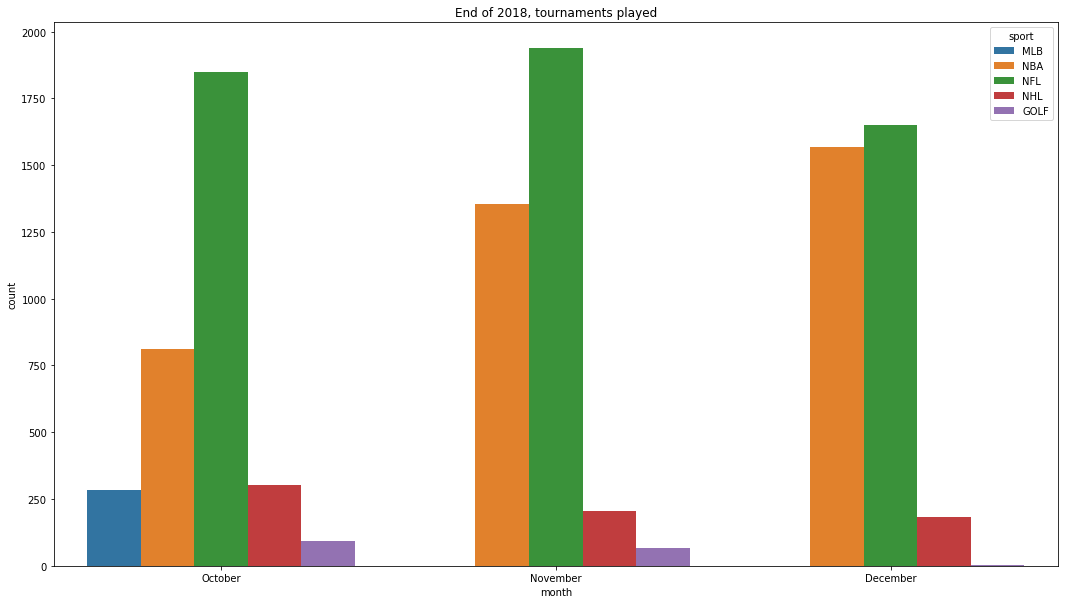

<Figure size 432x288 with 0 Axes>

In [312]:
import seaborn as sns

df['month'] = df['start'].apply(lambda x:x.strftime('%B'))
fig = plt.figure(figsize=(18,10))
sns.countplot(x="month", hue="sport", data=df).set_title('End of 2018, tournaments played')
plt.show()
plt.savefig('2018_end.png')

In [ ]:
with open('RG_{}_{}.json'.format(sdate, edate), 'a') as outfile:
        #    json.dump(data, outfile)

In [234]:
df = rg_df('RG_10-24-19_11-07-19.json')

In [ ]:
#df[df.gameCount.isna() == True]

In [227]:
df[df.isnull().any(axis=1)]

name sport  gameCount  \
57                  $40k thu nhl breakaway ($8k to 1st)   NHL      10.00   
58         $5k thu nhl big $2 double up (top 1,250 win)   NHL      10.00   
59                       $12k thu nhl goal ($2k to 1st)   NHL      10.00   
60                 $5k thu nhl wrister (20 entries max)   NHL      10.00   
61                                 $10k thu nhl monster   NHL      10.00   
62                          $8k thu nba piggy bank shot   NBA       3.00   
63                 $16k thu nba dribbler (single entry)   NBA       3.00   
64             $400k thu nba clutch shot ($100k to 1st)   NBA       3.00   
65               $30k thu nba fadeaway ($0.25 to enter)   NBA       3.00   
66            $10k thu nba pick n roll (20 entries max)   NBA       3.00   
67    $12k thu nba big $2 quintuple up - 5x (top 1,2...   NBA       3.00   
68                 $12k thu nba windmill (single entry)   NBA       3.00   
69        $20k thu nba big $2 double up (top 5,000 win)   NBA       3.00   
70                     $10k thu nba dime (single entry)   NBA       3.00   
71                     $8k thu nba swat (3 entries max)   NBA       3.00   
72                    $15k thu nba block (single entry)   NBA       3.00   
73                     $125k thu nba slam ($25k to 1st)   NBA       3.00   
74        $12k thu nba big $5 double up (top 1,200 win)   NBA       3.00   
75                     $60k thu nba layup ($10k to 1st)   NBA       3.00   
76    $11k thu nba epe shot (experienced players exc...   NBA       3.00   
77    $6k thu nba big $5 quintuple up - 5x (top 240 ...   NBA       3.00   
78                   $12k thu nba assist (single entry)   NBA       3.00   
79                  $6k thu nba swingman (single entry)   NBA       3.00   
80                  $5k thu nba rebound (5 entries max)   NBA       3.00   
81                $15k thu nba rainmaker (single entry)   NBA       3.00   
82                  $150k thu nba monster ($50k to 1st)   NBA       3.00   
83                   $100k thu nba baller ($50k to 1st)   NBA       3.00   
84          $5k thu nba big $25 double up (top 100 win)   NBA       3.00   
85                  $12k thu nba and one (single entry)   NBA       3.00   
86                     $9k thu nba swish (single entry)   NBA       3.00   
...                                                 ...   ...        ...   
2354                $33k thu nhl breakaway ($5k to 1st)   NHL      11.00   
2355                               $10k thu nhl monster   NHL      11.00   
2356                     $10k thu nhl goal ($2k to 1st)   NHL      11.00   
2378                        $7k thu nba piggy bank shot   NBA       4.00   
2379        $25k thu nba fadeaway (only $0.25 to enter)   NBA       4.00   
2380          $20k thu nba pick n roll (25 entries max)   NBA       4.00   
2381               $14k thu nba dribbler (single entry)   NBA       4.00   
2382                   $60k thu nba layup ($10k to 1st)   NBA       4.00   
2383           $400k thu nba clutch shot ($100k to 1st)   NBA       4.00   
2384      $16k thu nba big $5 double up (top 1,600 win)   NBA       4.00   
2385      $26k thu nba big $2 double up (top 6,500 win)   NBA       4.00   
2386                  $10k thu nba swat (3 entries max)   NBA       4.00   
2387      $6k thu nba epe shot (no experienced players)   NBA       4.00   
2388  $12k thu nba big $2 quintuple up - 5x (top 1,2...   NBA       4.00   
2389  $8k thu nba big $5 quintuple up - 5x (top 320 ...   NBA       4.00   
2390                   $125k thu nba slam ($25k to 1st)   NBA       4.00   
2391                   $12k thu nba dime (single entry)   NBA       4.00   
2392                  $16k thu nba block (single entry)   NBA       4.00   
2393                 $14k thu nba assist (single entry)   NBA       4.00   
2394                $12k thu nba charge (3 entries max)   NBA       4.00   
2395                $20k thu nba and one (single entry)   NBA       4.00   
2396                   

In [222]:
nfl = df[df.sport == 'NFL']
nhl = df[df.sport == 'NHL']
golf = df[df.sport == 'GOLF']
mlb = df[df.sport == 'MLB']
nba = df[df.sport == 'NBA']

In [242]:
labels = np.unique(df.sport.values).tolist()
labels

['GOLF', 'MLB', 'NBA', 'NFL', 'NHL']

In [263]:
gc = df.groupby("sport")['gameCount'].sum()
gc

sport
GOLF     26.00
MLB      63.00
NBA    5495.00
NFL    5751.00
NHL    1071.00
Name: gameCount, dtype: float64

In [264]:
pp = df.groupby("sport")['prizePool'].sum()

In [279]:
labels = np.unique(df.sport.values).tolist()
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen', 'lightblue']
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[gc[0], gc[1], gc[2], gc[3], gc[4]], name='Overall Tournaments Played'),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[pp[0], pp[1], pp[2], pp[3], pp[4]], name='Overall prizepool'),
              1, 2)

fig.update_traces(hole=.4, hoverinfo='label+name+value', marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
        title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    title_text='2019 Sport types comparsion',
    annotations=[dict(text='Tourney count', x=0.14, y=0.5, font_size=20, showarrow=False),
                 dict(text='Prizes sum', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [223]:
nfl.head(5)

name sport  gameCount  \
95  nfl showdown $80k bootleg [$20k to 1st] (was v...   NFL       1.00   
96  nfl showdown $95k luxury box [$50k to 1st] (wa...   NFL       1.00   
97  nfl showdown $150k deep threat [$50k to 1st] (...   NFL       1.00   
98  nfl $200k thursday night showdown [$50k to 1st...   NFL       1.00   
99  nfl showdown $60k play-action [20 entry max] (...   NFL       1.00   

   dayofweek               start  prizePool  entryFee  maxEntriesPerUser  \
95    Friday 2019-10-25 00:20:00   80000.00     33.00              84.00   
96    Friday 2019-10-25 00:20:00   95000.00   1500.00               2.00   
97    Friday 2019-10-25 00:20:00  150000.00    180.00              27.00   
98    Friday 2019-10-25 00:20:00  200000.00     10.00             150.00   
99    Friday 2019-10-25 00:20:00   60000.00      3.00              20.00   

    maxEntries  entryCount  
95     2827.00        2828  
96       67.00          68  
97      925.00         926  
98    23529.00       23530  
99    23781.00       23782

In [34]:
nfl.describe()

prizePool  entryFee  maxEntriesPerUser  maxEntries  entryCount
count      82.00     82.00              82.00       82.00       82.00
mean    63221.41    239.47              19.51    13685.78    13686.78
std    234061.65    671.99              38.48    37547.38    37547.38
min      5000.00      0.10               1.00       10.00       11.00
25%      6000.00      5.00               1.00      111.00      112.00
50%     12000.00     25.00               3.00      689.00      690.00
75%     25000.00    100.00              20.00     4562.25     4563.25
max   1500000.00   5375.00             150.00   176470.00   176471.00

In [35]:
nfl.prizePool.sum()

5184155.55

In [36]:
doubleups = nfl['name'].str.contains('Double Up').sum()
print ('Double ups количество в неделю: {} \nПроцент от общего числа турниров: {:.0f}%'.format(doubleups, doubleups/nfl.name.count()*100))

Double ups количество в неделю: 25 
Процент от общего числа турниров: 30%


In [114]:
nhl.head(5)

name sport  gameCount dayofweek  \
2       nhl $8k forecheck [20 entry max]   NHL          7    Monday   
3  nhl $5.2k power forward [2 entry max]   NHL          7    Monday   
4      nhl $15.6k sin bin [single entry]   NHL          7    Monday   
5       nhl $40k blue line [$10k to 1st]   NHL          7    Monday   
6               nhl $6.85k crease master   NHL          7    Monday   

                start  prizePool  entryFee  maxEntriesPerUser  maxEntries  \
2 2019-10-14 17:00:00    8000.00      4.00                 20        2378   
3 2019-10-14 17:00:00    5200.00     88.00                  2          67   
4 2019-10-14 17:00:00   15600.00   1500.00                  1          11   
5 2019-10-14 17:00:00   40000.00    222.00                  6         200   
6 2019-10-14 17:00:00    6850.00    691.00                  1          11   

   entryCount  
2        2379  
3          68  
4          12  
5         201  
6          12

In [207]:
nhl.describe()

prizePool  entryFee  maxEntriesPerUser  maxEntries  entryCount
count      19.00     19.00              19.00       19.00       19.00
mean    19127.37    199.66              24.32     2197.47     2192.89
std     29067.91    411.19              45.69     3430.90     3432.72
min      5000.00      0.50               1.00       10.00       11.00
25%      5000.00      5.00               1.00      169.00      170.00
50%      8000.00     20.00               3.00      583.00      584.00
75%     14810.00    104.50              20.00     1703.50     1704.50
max    100000.00   1500.00             150.00    11890.00    11891.00

In [46]:
nhl.prizePool.sum()

140650.0

In [217]:
doubleups = nhl['name'].str.contains('Double Up').sum()
print ('Double ups количество в неделю: {} \nПроцент от общего числа турниров: {:.0f}%'.format(doubleups, doubleups/nhl.name.count()*100))

Double ups количество в неделю: 1 
Процент от общего числа турниров: 5%


In [64]:
print (json_data[17]['entryCount'], '\n', json_normalize(json_data[17]['prizes']))

11891 
     cash  maxFinish  minFinish tierPayoutDescriptions.Cash  value
0   1000          1          1                   $1,000.00   1000
1    350          2          2                     $350.00    350
2    200          3          3                     $200.00    200
3    100          4          4                     $100.00    100
4     50          5          5                      $50.00     50
5     30          7          6                      $30.00     30
6     20         10          8                      $20.00     20
7     15         13         11                      $15.00     15
8     10         18         14                      $10.00     10
9      8         28         19                       $8.00      8
10     6         48         29                       $6.00      6
11     5         73         49                       $5.00      5
12     4        103         74                       $4.00      4
13     3        183        104                       $3.00      3
14

In [62]:
json_normalize(json_data[19]['prizes'])

cash  maxFinish  minFinish tierPayoutDescriptions.Cash  value
0   25000          1          1                  $25,000.00  25000
1   10000          2          2                  $10,000.00  10000
2    5000          3          3                   $5,000.00   5000
3    3500          4          4                   $3,500.00   3500
4    2500          5          5                   $2,500.00   2500
5    2000          7          6                   $2,000.00   2000
6    1500         10          8                   $1,500.00   1500
7    1000         13         11                   $1,000.00   1000
8     700         20         14                     $700.00    700
9     600         29         21                     $600.00    600
10    500         51         30                     $500.00    500
11    400        104         52                     $400.00    400

In [105]:
rg_2018 = get_data_rg('01/01/2018', '12/31/2018')

In [106]:
with open('rg_2018.json', 'w', encoding='utf-8') as f:
    json.dump(rg_2018, f, ensure_ascii=False, indent=4)

In [107]:
!ls 

nflgame.ipynb  simple_eda.ipynb     sportsref_download.csv  Untitled.ipynb
rg_2018.json   simple_eda-v2.ipynb  testdata.json


In [108]:
rg_2018

[{'_id': '5b45e8a262fa9e4e0fe5184e',
  'rgPrizePool': 28071,
  'rgPrizeWinnerCount': 197,
  'entryCount': 2811,
  'prizePool': 80000,
  'slateType': 1,
  'gameCount': None,
  'siteSlateId': '22721',
  'start': '2018-01-02T00:00:00.000Z',
  'sport': 4,
  'maxEntriesPerUser': None,
  'entryFee': 33,
  'name': '$80K Tue NHL SUPER Goal ($20K to 1st)',
  'siteContestId': '215048594',
  '_slateId': '5b45e8a062fa9e4e0fe509ef',
  'complete': True,
  'prizes': [{'maxFinish': 2795, 'minFinish': 1694, 'cash': 0},
   {'maxFinish': 560, 'minFinish': 560, 'cash': 20},
   {'maxFinish': 559, 'minFinish': 446, 'cash': 60},
   {'maxFinish': 314, 'minFinish': 314, 'cash': 64},
   {'maxFinish': 313, 'minFinish': 225, 'cash': 70},
   {'maxFinish': 163, 'minFinish': 163, 'cash': 77.5},
   {'maxFinish': 160, 'minFinish': 99, 'cash': 80},
   {'maxFinish': 65, 'minFinish': 37, 'cash': 100},
   {'maxFinish': 35, 'minFinish': 35, 'cash': 125},
   {'maxFinish': 34, 'minFinish': 24, 'cash': 150},
   {'maxFinish': 

In [109]:
rg_20182 = get_data_rg('01/02/2018', '12/31/2018')

In [110]:
rg_20182

[{'_id': '5ae4aa4c5689223dfaa52f9a',
  'rgPrizePool': 1820,
  'rgPrizeWinnerCount': 91,
  'entryCount': 574,
  'slateType': 3,
  'gameCount': 5,
  'siteSlateId': '17071',
  'start': '2018-01-03T00:00:00.000Z',
  'sport': 3,
  'prizePool': 5000,
  'maxEntriesPerUser': 1,
  'maxEntries': 574,
  'entryFee': 10,
  'name': 'NBA Single Entry $10 Double Up',
  'siteContestId': '52118200',
  '_slateId': '5aff63489109304c57c2ad30',
  'winner': {'users': [], 'score': None},
  'complete': True,
  'prizes': [{'value': 20,
    'tierPayoutDescriptions': {'Cash': '$20.00'},
    'minFinish': 1,
    'maxFinish': 250,
    'cash': 20}]},
 {'_id': '5ae4aac2c074cf3dffdc9ca0',
  'rgPrizePool': 2300,
  'rgPrizeWinnerCount': 23,
  'entryCount': 345,
  'slateType': 3,
  'gameCount': 5,
  'siteSlateId': '17071',
  'start': '2018-01-03T00:00:00.000Z',
  'sport': 3,
  'prizePool': 8000,
  'maxEntriesPerUser': 1,
  'maxEntries': 345,
  'entryFee': 27,
  'name': 'NBA $8K Fast Break [Single Entry]',
  'siteContestId

In [111]:
rg = rg_2018+rg_20182

In [112]:
rg

[{'_id': '5b45e8a262fa9e4e0fe5184e',
  'rgPrizePool': 28071,
  'rgPrizeWinnerCount': 197,
  'entryCount': 2811,
  'prizePool': 80000,
  'slateType': 1,
  'gameCount': None,
  'siteSlateId': '22721',
  'start': '2018-01-02T00:00:00.000Z',
  'sport': 4,
  'maxEntriesPerUser': None,
  'entryFee': 33,
  'name': '$80K Tue NHL SUPER Goal ($20K to 1st)',
  'siteContestId': '215048594',
  '_slateId': '5b45e8a062fa9e4e0fe509ef',
  'complete': True,
  'prizes': [{'maxFinish': 2795, 'minFinish': 1694, 'cash': 0},
   {'maxFinish': 560, 'minFinish': 560, 'cash': 20},
   {'maxFinish': 559, 'minFinish': 446, 'cash': 60},
   {'maxFinish': 314, 'minFinish': 314, 'cash': 64},
   {'maxFinish': 313, 'minFinish': 225, 'cash': 70},
   {'maxFinish': 163, 'minFinish': 163, 'cash': 77.5},
   {'maxFinish': 160, 'minFinish': 99, 'cash': 80},
   {'maxFinish': 65, 'minFinish': 37, 'cash': 100},
   {'maxFinish': 35, 'minFinish': 35, 'cash': 125},
   {'maxFinish': 34, 'minFinish': 24, 'cash': 150},
   {'maxFinish': 